In [1]:
epochs = 20
batch_size = 512
lr = 1e-3

In [2]:
import tensorflow as tf
import numpy as np
# num_words=10000 only keep the top 10,000 most frequently occurring words in the data
(x_train, y_train_cls), (x_test, y_test_cls) = tf.keras.datasets.reuters.load_data(num_words=10000)
y_train_cls = y_train_cls.astype(np.int32)
y_test_cls = y_test_cls.astype(np.int32)
word2int = tf.keras.datasets.reuters.get_word_index(path='reuters_word_index.json')
int2word = dict([(value, key) for (key, value) in word2int.items()])
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(8982,) (8982,) (2246,) (2246,)


In [3]:
# We decode the review; note that our indices were offset by 3 because
# 0 - "padding"
# 1 - "start of sequence"
# 2 - "unknown".
print(x_train[0])
print(' '.join([int2word.get(i - 3, '?') for i in x_train[0]]))
print(y_train_cls[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
3


In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results
x_train = vectorize_sequences(x_train) 
x_test = vectorize_sequences(x_test) 
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(8982, 10000) (8982,) (2246, 10000) (2246,)


In [5]:
y_train = np.squeeze(np.eye(46)[y_train_cls]).astype(np.int32)
y_test = np.squeeze(np.eye(46)[y_test_cls]).astype(np.int32)
print(x_train.shape, y_train.shape, y_train_cls.shape, x_test.shape, y_test.shape, y_test_cls.shape)

(8982, 10000) (8982, 46) (8982,) (2246, 10000) (2246, 46) (2246,)


In [6]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [7]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation=None))

x = model.input
y = tf.placeholder(tf.int32, (None, 46)) 
y_cls = tf.placeholder(tf.int32, (None,)) 
 
logits = model.output
y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y_cls, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using TensorFlow backend.


In [8]:
def shuffle_batch(x, y, y_cls, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx], y_cls[batch_idx]

In [9]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch, y_batch_cls in shuffle_batch(x_train, y_train, y_train_cls, batch_size):
            feed_dict = {x: x_batch, y: y_batch, y_cls: y_batch_cls}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test, y_cls: y_test_cls}
    accuracy_run, y_test_pred_cls = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/20 
epoch 1/20 
epoch 2/20 
epoch 3/20 
epoch 4/20 
epoch 5/20 
epoch 6/20 
epoch 7/20 
epoch 8/20 
epoch 9/20 
epoch 10/20 
epoch 11/20 
epoch 12/20 
epoch 13/20 
epoch 14/20 
epoch 15/20 
epoch 16/20 
epoch 17/20 
epoch 18/20 
epoch 19/20 

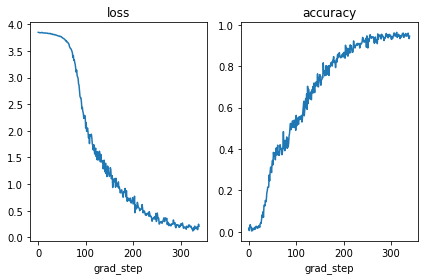

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [11]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.7938557


In [12]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)
print(cm)

[[ 9  1  0 ...  0  0  0]
 [ 0 84  0 ...  0  0  0]
 [ 0  2 12 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]
